In [1]:
from pathlib import Path
import requests
from tqdm import tqdm

phoible_data_url = "https://raw.githubusercontent.com/phoible/dev/v2.0/data/phoible.csv"
phobile_file_path = "./downloads/phoible.csv"

VALIDATE_RESULTS = True

if not Path(phobile_file_path).exists():
    response = requests.get(phoible_data_url, stream=True)

    with open(phobile_file_path, "wb") as fh:
        for data in tqdm(response.iter_content()):
            fh.write(data)

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np

phoible_df = pd.read_csv(phobile_file_path, encoding="utf-8", engine="python")

print(phoible_df.shape)

lang_by_dialect_df = (phoible_df[["LanguageName", "SpecificDialect", "Phoneme"]]
                         .fillna({"SpecificDialect": "none"})
                         .groupby(["LanguageName", "SpecificDialect"]))

num_lang = len(lang_by_dialect_df)

Matplotlib is building the font cache; this may take a moment.


(105467, 48)


In [3]:
# util

def create_symbol_matrix(phoneme_type_df):
    phoneme_type_long_df = phoneme_type_df.map(lambda c: c + "ː" if type(c) ==  str else c)
    symbols = set(phoneme_type_df.stack().replace("", np.nan).dropna().unique().tolist())
    symbols_long = set([c + "ː" for c in symbols])

    def map_phonemes(df):
        phonemes = set(df.Phoneme.to_list())
        valid_symbols = phonemes.intersection(symbols)
        valid_symbols_long = phonemes.intersection(symbols_long)
        
        standard = np.where(phoneme_type_df.isin(valid_symbols), 1., 0.)
        long = np.where(phoneme_type_long_df.isin(valid_symbols_long), 2., 0.)

        result = np.add(standard, long)

        if VALIDATE_RESULTS:
            for row, _ in enumerate(standard):
                for col,  _ in enumerate(standard.T):
                    assert standard[row][col] + long[row][col] == result[row][col]

            assert standard.sum() == len(valid_symbols)
            assert long.sum() == len(valid_symbols_long) * 2
            assert result.sum() == len(valid_symbols) + (len(valid_symbols_long) * 2)

        return result

    return map_phonemes

Generate pulomic consonants data.

In [4]:
cons_pl_df = pd.read_csv("./data/consonants_plumonic.csv", dtype=str, index_col=[0], keep_default_na=False, na_values=["-1"])
cons_pl_long_df = cons_pl_df.map(lambda c: c + "ː" if type(c) ==  str else c)
cons_pl_df

,Bilabial,Bilabial_v,Labiodental,Labiodental_v,Dental,Dental_v,Alveolar,Alveolar_v,Postalveolar,Postalveolar_v,...,Palatal,Palatal_v,Velar,Velar_v,Uvular,Uvular_v,Pharyngeal,Pharyngeal_v,Glottal,Glottal_v
Plosive,p,b,,,t̪,d̪,t,d,,,...,c,ɟ,k,ɡ,q,ɢ,,NaN,ʔ,NaN
Nasal,,m,,ɱ,,n̪,,n,,,...,,ɲ,,ŋ,,ɴ,NaN,NaN,NaN,NaN
Trill,,ʙ,,,,r̪,,r,,,...,,,NaN,NaN,,ʀ,,,NaN,NaN
Tap or Flap,,,,ⱱ,,ɾ̪,,ɾ,,,...,,,NaN,NaN,,,,,NaN,NaN
Fricative,ɸ,β,f,v,θ,ð,s,z,ʃ,ʒ,...,ç,ʝ,x,ɣ,χ,ʁ,ħ,ʕ,h,ɦ
Lateral fricative,NaN,NaN,NaN,NaN,,,ɬ,ɮ,,,...,,,,,,,NaN,NaN,NaN,NaN
Approximant,,,,ʋ,,,,ɹ,,,...,,j,,ɰ,,,,,NaN,NaN
Lateral approximant,NaN,NaN,NaN,NaN,,l̪,,l,,,...,,ʎ,,ʟ,,,NaN,NaN,NaN,NaN


In [5]:
cons_pl_npy = np.stack(lang_by_dialect_df.apply(create_symbol_matrix(cons_pl_df), include_groups=False).to_numpy())
assert cons_pl_npy.shape == (num_lang, *cons_pl_df.shape)
np.save("./data/consonants_plumonic.npy", cons_pl_npy)
cons_pl_npy.shape

(2949, 8, 22)

Generate non-pulomic consonants data.

In [6]:
cons_npl_df = pd.read_csv("./data/consonants_non_plumonic.csv", dtype=str, index_col=[0], keep_default_na=False, na_values=["-1"])
cons_npl_long_df = cons_npl_df.map(lambda c: c + "ː" if type(c) ==  str else c)
cons_npl_df

,0,1,2,3,4,5,6,7
Ejective Stop,pʼ,tʼ,ʈʼ,cʼ,kʼ,qʼ,ʡʼ,
Ejective Fricative,fʼ,θʼ,sʼ,ʃʼ,ʂʼ,ɕʼ,xʼ,χʼ
Ejective Affricate,tsʼ,t̠ʃʼ,ʈʂʼ,kxʼ,qχʼ,,,
Ejective Lateral,ɬʼ,tɬʼ,cʎ̝̊ʼ,kʟ̝̊ʼ,,,,
Click,kʘ,kǀ,kǃ,kǂ,kǁ,,,
Implosive Voiced,ɓ,ɗ,ᶑ,ʄ,ɠ,ʛ,,
Implosive Voiceless,ɓ̥,ɗ̥,ᶑ̥,ʄ̥,ɠ̊,ʛ̥,,


In [7]:
cons_npl_npy = np.stack(lang_by_dialect_df.apply(create_symbol_matrix(cons_npl_df), include_groups=False).to_numpy())
assert cons_npl_npy.shape == (num_lang, *cons_npl_df.shape)
np.save("./data/consonants_non_plumonic.npy", cons_npl_npy)
cons_npl_npy.shape

(2949, 7, 8)

Generate vowel data.

In [8]:
vowels_df = pd.read_csv("./data/vowels.csv", dtype=str, index_col=[0], keep_default_na=False, na_values=["-1"])
vowels_long_df = vowels_df.map(lambda c: c + "ː" if type(c) ==  str else c)
vowels_df

,Front unrounded,Front rounded,Near-front unrounded,Near-front rounded,Central unrounded,Central rounded,Near-back unrounded,Near-back rounded,Back unrounded,Back rounded
Close,i,y,,,ɨ,ʉ,,,ɯ,u
Near-close,,,ɪ,ʏ,,,,ʊ,,
Close-mid,e,ø,,,ɘ,ɵ,,,ɤ,o
Mid,e̞,ø̞,,,ə,,,,ɤ̞,o̞
Open-mid,ɛ,œ,,,ɜ,ɞ,,,ʌ,ɔ
Near-open,æ,,,ɐ,,,,,,
Open,a,ɶ,,,ä,,,,ɑ,ɒ


In [9]:
vowels_npy = np.stack(lang_by_dialect_df.apply(create_symbol_matrix(vowels_df), include_groups=False).to_numpy())
assert vowels_npy.shape == (num_lang, *vowels_df.shape)
np.save("./data/vowels.npy", vowels_npy)

In [10]:
(cons_pl_npy.shape, cons_npl_npy.shape, vowels_npy.shape)

((2949, 8, 22), (2949, 7, 8), (2949, 7, 10))

Merge all the data into a single 3d array. Each language is represented by a 2d matrix, with columns of the 3 phoneme types stacked in 3 groups and a padding column between each group.

In [11]:
max_rows = max(
    cons_pl_npy.shape[1], 
    cons_npl_npy.shape[1], 
    vowels_npy.shape[1]
)

def get_padding(arr, max_rows, col_padding=0):
    return ((0, 0), (0, max_rows - arr.shape[1]), (0, col_padding))

language_phonemes_npy = np.dstack([
    np.pad(cons_pl_npy, get_padding(cons_pl_npy, max_rows, col_padding=1), mode='constant'), 
    np.pad(cons_npl_npy, get_padding(cons_npl_npy, max_rows, col_padding=1), mode='constant'), 
    np.pad(vowels_npy, get_padding(vowels_npy, max_rows), mode='constant')
])
language_phonemes_npy.shape

(2949, 8, 42)

In [12]:
np.save("./data/language_phonemes.npy", language_phonemes_npy)

Investigating unhandled phonemes.

In [13]:
handled_symbols =  (
    set(cons_pl_df.stack().replace("", np.nan).dropna().unique()) |
    set(cons_npl_df.stack().replace("", np.nan).dropna().unique()) |
    set(vowels_df.stack().replace("", np.nan).dropna().unique())
)
handled_symbols_long = set([c + "ː" for c in handled_symbols])
all_handled_symbols = handled_symbols | handled_symbols_long
len(all_handled_symbols)

278

,LanguageName,Phoneme
1,!Xóõ,126.0
0,!XU,107.0
2,!Xun,94.0
1979,Soghpo Tibetan,85.0
1424,Mbembe,84.0
...,...,...
2168,Trió,1.0
229,Badaga,1.0
2149,Tiwi,1.0
964,KOMA,1.0


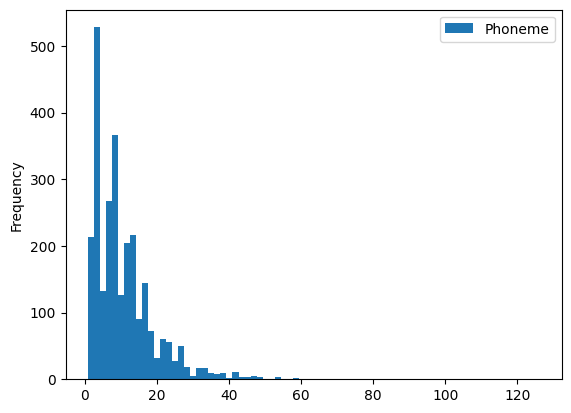

In [22]:
unhandled_symbols = phoible_df[~phoible_df.Phoneme.isin(all_handled_symbols)][["LanguageName", "SpecificDialect", "Phoneme"]]

unhandled_symbols_by_dialect = (unhandled_symbols
                         .fillna({"SpecificDialect": "none"})
                         .drop_duplicates()
                         .groupby(["LanguageName", "SpecificDialect"]))

unhandled_counts = (unhandled_symbols_by_dialect
                         .count()
                         .reset_index()
                         .groupby("LanguageName")
                         .mean("Phoneme")
                         .reset_index()
                         .sort_values("Phoneme", ascending=False))

unhandled_counts.plot.hist(bins=75)

unhandled_counts
